In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sys
import time
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True,precision=6)
tf.reset_default_graph()

PERIOD=6
DIM=2
LABLES=12
EPOCH=10000
BATCH_SIZE=80
REGULAR_LAMBDA=0.1
POINT=100000
LR=0.001
KEEP_PROB=0.5

def get_datafame(fname):
    df=pd.read_csv(fname,header=None)
    df.columns=['date','time','open','high','low','close','volume']
    df['timestamp']=df['date']+' '+df['time']
    df['timestamp']=df['timestamp'].apply(lambda x:time.mktime(time.strptime(x,'%Y.%m.%d %H:%M'))/time.mktime(time.strptime('2082-02-11 00:00','%Y-%m-%d %H:%M')))
    df['co']=(df['close']-df['open'])*POINT
    return df

def get_data(fname):
    df=get_datafame(fname)
    xi=[];yi=[]
    for i in range(PERIOD,PERIOD+2):
    #for i in range(PERIOD,len(df)):
        xi.append(df['co'][i-PERIOD:i].tolist())
        il=df.iloc[i]['co']/10
        if il>LABLES/2:il=LABLES/2
        if il<-LABLES/2:il=-LABLES/2
        yl=np.zeros([LABLES])
        yl[int(il)]=1
        yi.append(yl)
    xi=np.array(xi)
    return (xi,yi)
print(get_data('1.csv'))
exit()

STDDEV=1/tf.sqrt(tf.cast(BATCH_SIZE,tf.float32))
def weight_variable(shape,name):
    initial = tf.truncated_normal(shape, STDDEV)
    var=tf.Variable(initial,name=name)
    tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(REGULAR_LAMBDA)(var))
    return var
def bias_variable(shape,name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial,name=name)


sess=tf.Session()
xs=tf.placeholder(tf.float32,shape=[BATCH_SIZE,PERIOD],name="xs")
ys=tf.placeholder(tf.float32,shape=[BATCH_SIZE,1],name="ys")

SIZES=[33,100,33,1]
w1=weight_variable([PERIOD,SIZES[0]],name="w1")
b1=bias_variable([SIZES[0]],name="b1")

w2=weight_variable([SIZES[0],SIZES[1]],name="w2")
b2=bias_variable([SIZES[1]],name="b2")

w3=weight_variable([SIZES[1],SIZES[2]],name="w3")
b3=bias_variable([SIZES[2]],name="b3")

w4=weight_variable([SIZES[2],SIZES[3]],name="w4")
b4=bias_variable([SIZES[3]],name="b4")

#w5=weight_variable([SIZES[3],SIZES[4]],name="w5")
#b5=bias_variable([SIZES[4]],name="b5")

y=tf.nn.xw_plus_b(xs,w1,b1)
y=tf.nn.xw_plus_b(y,w2,b2)
y=tf.nn.tanh(y)
y=tf.nn.xw_plus_b(y,w3,b3)
y=tf.nn.tanh(y)
y=tf.nn.dropout(y,KEEP_PROB)
y=tf.nn.xw_plus_b(y,w4,b4)
#y=tf.nn.elu(y)
#y=tf.nn.xw_plus_b(y,w5,b5)

mse=tf.losses.mean_squared_error(y,ys)
#cse=tf.losses.softmax_cross_entropy(ys,y)
tf.add_to_collection("losses",mse) 
regular_loss = tf.add_n(tf.get_collection('losses'))
loss=mse+regular_loss
train_op = tf.train.AdamOptimizer(LR).minimize(loss) # 调

#tf.summary.scalar("ac",0.5)
#merged = tf.summary.merge_all()

train_writer = tf.summary.FileWriter('./train',sess.graph)
test_writer = tf.summary.FileWriter('./test')
train_data=get_data('1.csv');
valid_data=get_data('2.csv')
sess.run(tf.global_variables_initializer())
_last_vloss=np.infty;_loss=0;_vloss=0
for epoch in range(0,EPOCH):   
    for i in range(0,len(train_data),BATCH_SIZE):
        _x=train_data[0][i:i+BATCH_SIZE]
        _y=train_data[1][i:i+BATCH_SIZE]
        _,_loss=sess.run([train_op,loss],feed_dict={xs:_x,ys:_y})
        _x=valid_data[0][0:BATCH_SIZE]
        _y=valid_data[1][0:BATCH_SIZE]
        _vloss=sess.run(loss,feed_dict={xs:_x,ys:_y})
        print("loss:%.6f vloss:%.6f"%(_loss,_vloss))
    #if _vloss<_last_vloss:_last_vloss=_vloss
    #else:break
print("loss:%.6f vloss:%.6f"%(_loss,_vloss))
print('finished') 
        



(array([[-1.,  4.,  2.,  9., -2., 14.],
       [ 4.,  2.,  9., -2., 14., -5.]]), [array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])])


ValueError: Cannot feed value of shape (2, 6) for Tensor 'xs:0', which has shape '(80, 6)'

[  8.661175   1.902454  -5.423771 -15.161208   7.99613    3.410667
  10.390889   9.688124  -8.865829  -3.518282  -1.423516  16.208454
  -0.423925  -1.993311 -10.033792  -3.204207   6.071811  10.89071
   5.917678  17.517506  -6.473838   1.478887  10.361313 -21.469868
  -2.304347  16.593435 -11.629473  13.288113  -4.717714  -5.075079
  -2.624284   1.387214   5.95072  -17.930939   9.758787  -2.609537
  10.771622  19.701962  -8.338695   9.025295 -20.938894  16.968864
  -8.174603  15.339525  -1.955594  18.078691  -7.37496    0.837456
  11.963543   5.491149 -14.691153  19.590462 -17.898027  -8.81737
  14.076649 -16.881424  -5.891152   4.918549  -2.825439  -4.904507
  -2.422072  -0.732842   1.752807  10.041644  -4.311259 -10.844314
   1.880689  18.592632  13.264027 -32.03954    3.423624 -27.162846
  30.270622 -24.9539     2.200675  10.051837   8.865123   6.315265
   1.52416   20.189827]
[  5.  -1.  -1.  -6.   3.   0.  11.   5.  -6.   0.  -2.  12.   1.   2.
  -5.  -4.   5.  13.   4.  17. -13. 

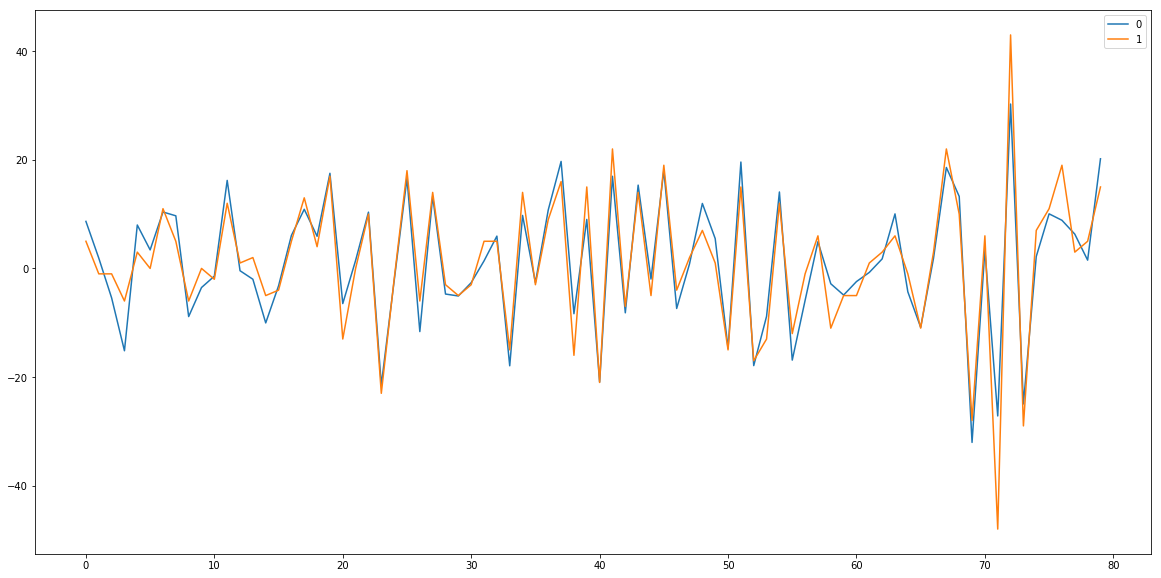

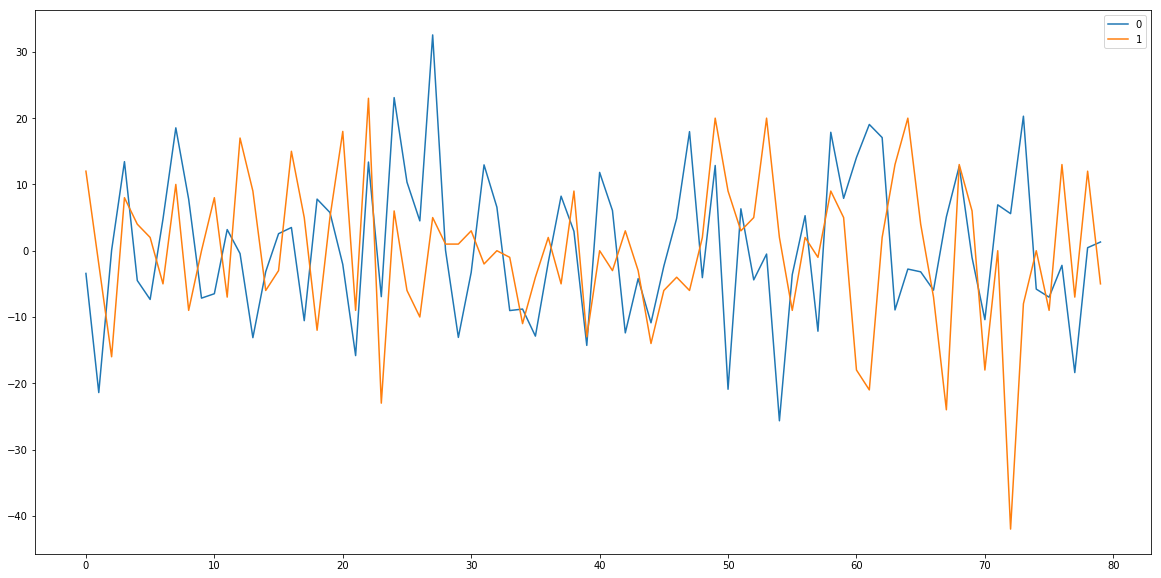

In [161]:
KEEP_PROB=1
_x=train_data[0][0:0+BATCH_SIZE]
_y=train_data[1][0:0+BATCH_SIZE]
_yt=sess.run(y,feed_dict={xs:_x,ys:_y})
_yt=_yt.reshape(BATCH_SIZE)
_y=np.array(_y).reshape(BATCH_SIZE)
#print(train_data[0][0:100])
print(_yt)
print(_y)
a=[_yt.tolist(),_y.tolist()]
#print(a)
df=pd.DataFrame(a).T
df.plot(figsize=(20,10))
_x=valid_data[0][0:0+BATCH_SIZE]
_y=valid_data[1][0:0+BATCH_SIZE]
_yt=sess.run(y,feed_dict={xs:_x,ys:_y})
#print(_yt)
a=[_yt.reshape(BATCH_SIZE).tolist(),np.array(_y).reshape(BATCH_SIZE).tolist()]
#print(a)
df=pd.DataFrame(a).T
df.plot(figsize=(20,10))

In [12]:
import pandas as pd
import numpy as np
import math
POINT=100000
PERIOD=6
LABLES=13
def get_datafame(fname):
    df=pd.read_csv(fname,header=None)
    df.columns=['date','time','open','high','low','close','volume']
    df['timestamp']=df['date']+' '+df['time']
    #df['timestamp']=df['timestamp'].apply(lambda x:time.mktime(time.strptime(x,'%Y.%m.%d %H:%M'))/time.mktime(time.strptime('2082-02-11 00:00','%Y-%m-%d %H:%M')))
    df['co']=(df['close']-df['open'])*POINT
    return df

df=get_datafame('1.csv')
df
xi=[];yi=[]
for i in range(PERIOD,PERIOD+2):
#for i in range(PERIOD,len(df)):
    xi.append(df['co'][i-PERIOD:i].tolist())
    il=df.iloc[i]['co']/10
    print(il)
    print(int(round(il+LABLES/2)))
    if il>LABLES/2:il=LABLES/2
    if il<-LABLES/2:il=-LABLES/2
    yl=np.zeros([LABLES])
    yl[int(il+LABLES/2)]=1
    yi.append(yl)
#xi=np.array(xi)
print(yi)    


-0.49999999999994493
6
-0.9000000000014552
6
[array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])]


In [2]:
df

,date,time,open,high,low,close,volume,timestamp,co
0,2017.11.01,00:00,0.98737,0.98737,0.98726,0.98736,0,2017.11.01 00:00,-1.0
1,2017.11.01,00:01,0.98738,0.98748,0.98737,0.98742,0,2017.11.01 00:01,4.0
2,2017.11.01,00:02,0.98743,0.98746,0.98740,0.98745,0,2017.11.01 00:02,2.0
3,2017.11.01,00:03,0.98745,0.98754,0.98744,0.98754,0,2017.11.01 00:03,9.0
4,2017.11.01,00:04,0.98753,0.98755,0.98749,0.98751,0,2017.11.01 00:04,-2.0
5,2017.11.01,00:05,0.98750,0.98766,0.98748,0.98764,0,2017.11.01 00:05,14.0
6,2017.11.01,00:06,0.98764,0.98768,0.98753,0.98759,0,2017.11.01 00:06,-5.0
7,2017.11.01,00:07,0.98757,0.98765,0.98745,0.98748,0,2017.11.01 00:07,-9.0
8,2017.11.01,00:08,0.98747,0.98749,0.98742,0.98743,0,2017.11.01 00:08,-4.0
9,2017.11.01,00:09,0.98742,0.98750,0.98742,0.98750,0,2017.11.01 00:09,8.0


In [26]:
weights=np.random.randn(5,10)
df=pd.read_csv('test.csv',header=None)
a=np.array(df[0:10][5])
#a=a[:,np.newaxis]
b=np.matmul(weights,a)
b

array([ 4.01775283,  0.74377105,  3.55656728,  0.96495522, -1.73225532])

In [27]:
a=[[1,2,3],[4,5,6]]
b=[1,2,3]
c=np.matmul(a,b)
c

array([14, 32])

In [28]:
np.random.randint(0,10)

5